In [1]:

from scipy.stats import pearsonr
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from Config import get_data_dir


In [2]:
main_dir = './Models'

# Collect the data for each training mode
data = {}
for mode_dir in glob.glob('{}/*'.format(main_dir)):
    mode = mode_dir.split('/')[-1]
    
    if mode != 'initial-transfer' and mode.split('-')[0] != 'partial': #Ignore the models we aren't analyzing
        # Aggregate the data for that mode across the trials
        data_mode = {}
        count = 0
        for trial_dir in glob.glob('{}/trial*'.format(mode_dir)):
            with open('{}/results.json'.format(trial_dir), 'r') as f:
                data_tmp = json.load(f)
            for key in data_tmp:
                if key in data_mode:
                    data_mode[key].append(data_tmp[key])
                else:
                    data_mode[key] = [data_tmp[key]]

        # We want the average
        for key in data_mode:
            data_tmp = data_mode[key]
            data_mode[key] = '{} ({})'.format(np.round(np.mean(data_tmp), 3), np.round(np.std(data_tmp), 3))

        # Compute aggregated accuracy metrics
        data[mode] = data_mode

# Convert the nested dictionary into a csv
modes = [key for key in data]
modes.sort()
metrics = [key for key in data[modes[0]]]

# Group the results by pair
with open('./FindSCs.json', 'r') as f:
    pairs = json.load(f)

metric_groups = {}
metric_groups['avg'] = [('MAP', 'MAP'), ('MAR', 'MAR')]

for pair in pairs:
    n = len(pair)
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    n_main = len(main)
    tmp = []
    for metric in metrics:
        if metric[:n] == pair:
            name = metric[n+1:]
            tmp.append((name, metric))
    metric_groups[pair] = tmp

# Save the results
for group in metric_groups:

    df = pd.DataFrame()
    df['Mode'] = modes
    for info in metric_groups[group]:
        name = info[0]
        metric = info[1]
        data_tmp = []
        for mode in modes:
            data_tmp.append(data[mode][metric])
        df[name] = data_tmp

    df.to_csv('./Analysis/{}.csv'.format(group), index = False)

In [3]:
# Show the results for each object pair and then the aggregated differences

def remove_var_info(df):
    def remove(x):
        return x.split(' ')[0]
    return df.applymap(remove)

groups = {}
for pair in pairs:
    spurious = pair.split('-')[1]    
    if spurious in groups:
        groups[spurious].append(pair)
    else:
        groups[spurious] = [pair]

cols_acc = ['Mode', 'both', 'just_main', 'just_spurious', 'neither', 'b-precision', 'b-recall', 'r-gap', 'p-with', 'p-without']
    
def compare(corrected, baseline):
    modes = [corrected, baseline]

    diffs_acc = {}
    for metric in cols_acc[1:]:
        diffs_acc[metric] = []

    for key in groups:
        group = groups[key]
        print()
        print()
        print(key)
        print()
        for pair in group:

            print(pair)
                        
            with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
                splits = json.load(f)
                
            for split in splits:
                splits[split] = len(splits[split])
            
            P_S = (splits['both'] + splits['just_spurious']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S_g_M = splits['both'] / (splits['both'] + splits['just_main'])            
            print('P(S|M), P(S):', np.round(P_S_g_M, 3), np.round(P_S, 3))
            
            df = pd.read_csv('./Analysis/{}.csv'.format(pair))

            print('Acc Comparison')
            df_tmp = remove_var_info(df.loc[df['Mode'].isin(modes), cols_acc].copy())
            print(df_tmp.to_string(index = False)) 

            for metric in diffs_acc:
                data_tmp = {}
                names = df_tmp['Mode'].values
                values = df_tmp[metric].values
                for i in range(len(names)):
                    data_tmp[names[i]] = float(values[i])
                if not np.any(data_tmp == -1):
                    diffs_acc[metric].append(data_tmp[modes[0]] - data_tmp[modes[1]])
            print()
            print()

    print()
    print()
    print()
    print()
    print('Aggregate Differences:')
    
    def get_stats(key, diffs):
        print(key)
        data = diffs[key]
        print('mean (std):', np.round(np.mean(data), 3), np.round(np.std(data), 3))
        print('median:', np.round(np.median(data), 3))
        if key in ['r-gap']:
            print('prob < 0:',  np.round(np.mean(np.array(data) < 0), 3))
        else:
            print('prob > 0:',  np.round(np.mean(np.array(data) > 0), 3))
        print()
        print()

    for key in diffs_acc:
        plt.hist(diffs_acc[key], bins = 15)
        plt.title(key)
        plt.show()
        plt.close()
        get_stats(key, diffs_acc)




person

cell+phone-person
P(S|M), P(S): 0.797 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      auto-v1  0.232     0.392          0.99   0.994       0.637    0.312   0.16  0.504     0.313
 initial-tune  0.282     0.324         0.985   0.996       0.596    0.303  0.042  0.516     0.243


handbag-person
P(S|M), P(S): 0.91 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      auto-v1  0.137     0.042         0.992   0.998       0.569    0.089  0.095   0.65     0.028
 initial-tune  0.242     0.008         0.975   0.999       0.395    0.125  0.234  0.542     0.001


donut-person
P(S|M), P(S): 0.548 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      auto-v1   0.25     0.448         0.997   0.997       0.646    0.349  0.198  0.423     0.529
 initial-tune  0.273      0.44    

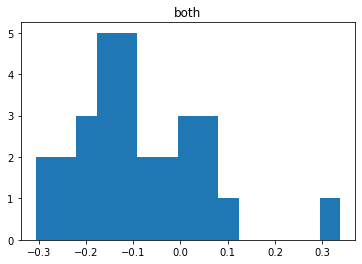

both
mean (std): -0.085 0.133
median: -0.1
prob > 0: 0.276




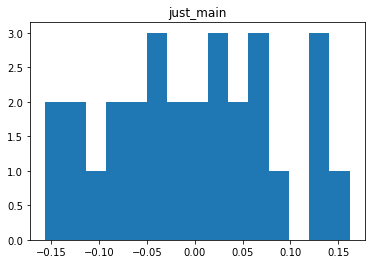

just_main
mean (std): -0.001 0.086
median: -0.003
prob > 0: 0.483




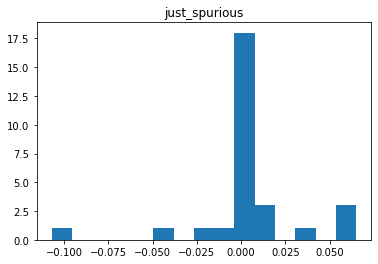

just_spurious
mean (std): 0.004 0.03
median: 0.003
prob > 0: 0.655




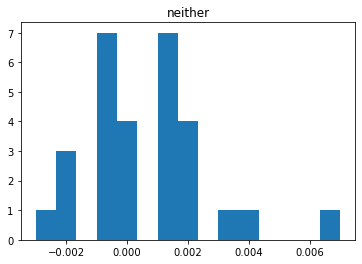

neither
mean (std): 0.0 0.002
median: 0.0
prob > 0: 0.483




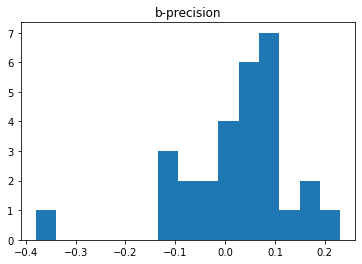

b-precision
mean (std): 0.023 0.112
median: 0.041
prob > 0: 0.69




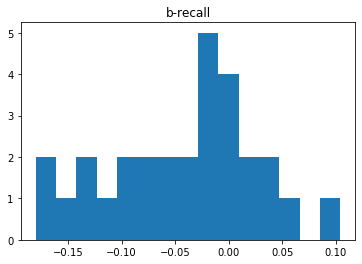

b-recall
mean (std): -0.043 0.07
median: -0.027
prob > 0: 0.276




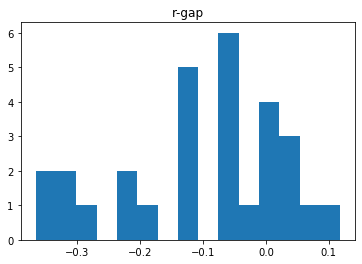

r-gap
mean (std): -0.104 0.131
median: -0.072
prob < 0: 0.759




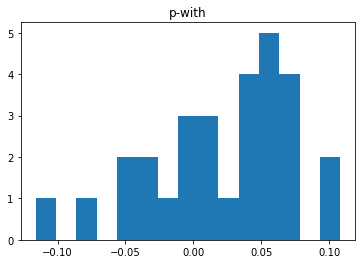

p-with
mean (std): 0.022 0.052
median: 0.034
prob > 0: 0.69




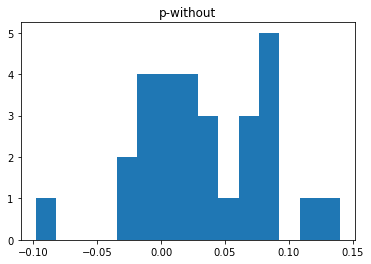

p-without
mean (std): 0.033 0.051
median: 0.027
prob > 0: 0.69




In [4]:
compare('auto-v1', 'initial-tune')



person

cell+phone-person
P(S|M), P(S): 0.797 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune  0.247     0.227         0.986   0.998        0.58    0.237  0.021  0.525      0.21
 initial-tune  0.282     0.324         0.985   0.996       0.596    0.303  0.042  0.516     0.243


handbag-person
P(S|M), P(S): 0.91 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune  0.225       0.0         0.975   0.999       0.361    0.113  0.225  0.514       0.0
 initial-tune  0.242     0.008         0.975   0.999       0.395    0.125  0.234  0.542     0.001


donut-person
P(S|M), P(S): 0.548 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune  0.242     0.474         0.998   0.998       0.731    0.358  0.232  0.517     0.636
 initial-tune  0.273      0.44    

 initial-tune  0.379     0.197         0.911   0.996       0.167    0.288  0.182  0.379     0.198


bowl-dining+table
P(S|M), P(S): 0.478 0.1
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune  0.498     0.324         0.892    0.99       0.331    0.411  0.174  0.487     0.406
 initial-tune   0.54     0.353         0.871   0.991       0.316    0.447  0.187  0.498     0.416




sheep

dog-sheep
P(S|M), P(S): 0.026 0.013
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune  0.342     0.616         0.937   0.985       0.329    0.479  0.275  0.027     0.619
 initial-tune    0.2     0.574         0.942   0.992       0.424    0.387  0.374  0.025     0.723


bird-sheep
P(S|M), P(S): 0.013 0.013
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall  r-gap p-with p-without
      fs-tune   0.21     0.358           

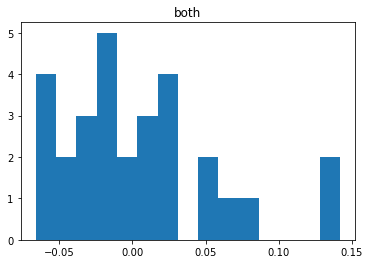

both
mean (std): 0.006 0.051
median: 0.0
prob > 0: 0.483




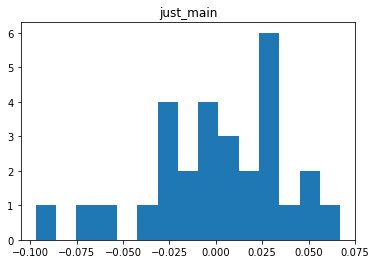

just_main
mean (std): 0.001 0.037
median: 0.005
prob > 0: 0.517




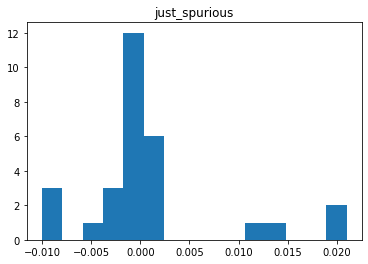

just_spurious
mean (std): 0.001 0.007
median: 0.0
prob > 0: 0.345




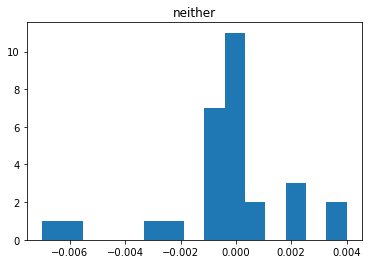

neither
mean (std): -0.0 0.002
median: 0.0
prob > 0: 0.241




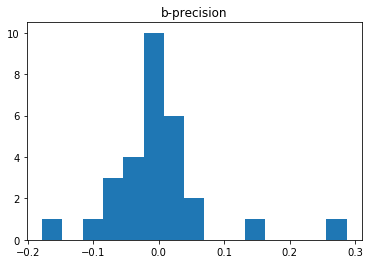

b-precision
mean (std): 0.0 0.076
median: -0.003
prob > 0: 0.414




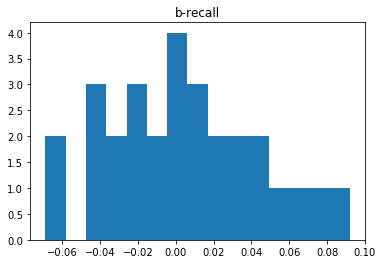

b-recall
mean (std): 0.003 0.04
median: 0.002
prob > 0: 0.517




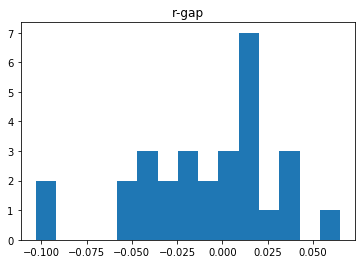

r-gap
mean (std): -0.009 0.038
median: 0.0
prob < 0: 0.483




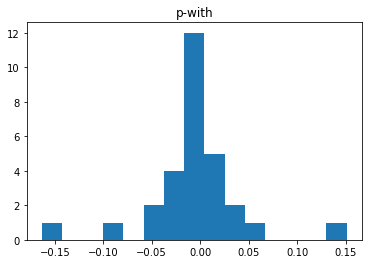

p-with
mean (std): -0.006 0.048
median: -0.005
prob > 0: 0.448




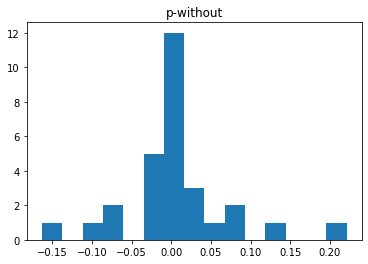

p-without
mean (std): 0.004 0.068
median: -0.001
prob > 0: 0.448




In [5]:
compare('fs-tune', 'initial-tune')